In [1]:
import json
import os
import pandas as pd
import numpy as np
from pathlib import Path
from PIL.ImageChops import constant
from Scripts.pywin32_testall import project_root
from scipy.stats import obrientransform
import sys
from matplotlib import pyplot as plt
from pathlib import Path
project_root = Path(__file__).resolve().parents[1] if "__file__" in globals() else Path().resolve().parent
sys.path.append(str(project_root))
from src.utils.eda_utils import missingness

In [2]:
Root_dir = Path.cwd().parent
data_dir = Path(Root_dir.joinpath('data/raw/tlc/yellow/2023'))
zone_path = Path(Root_dir.joinpath('data/raw/tlc/misc/taxi_zone_lookup.csv'))
file_1 = Path(data_dir.joinpath('yellow_tripdata_2023-01.parquet'))

In [3]:
df = pd.read_parquet(file_1)

In [4]:
mt = missingness(df)

In [5]:
output_path = Path(Root_dir.joinpath('reports/tables/missingness_table.csv'))
output_path.parent.mkdir(parents=True, exist_ok=True)
mt.to_csv(output_path, index=False)
mt

,name,dtype,n_missing,%missing,n_non_missing,n_unique,all_missing,constant,infinite
0,RatecodeID,float64,71743,2.339,2995023,7,False,False,0
1,airport_fee,float64,71743,2.339,2995023,3,False,False,0
2,congestion_surcharge,float64,71743,2.339,2995023,3,False,False,0
3,passenger_count,float64,71743,2.339,2995023,10,False,False,0
4,store_and_fwd_flag,object,71743,2.339,2995023,2,False,False,0
5,DOLocationID,int64,0,0.000,3066766,261,False,False,0
6,PULocationID,int64,0,0.000,3066766,257,False,False,0
7,VendorID,int64,0,0.000,3066766,2,False,False,0
8,extra,float64,0,0.000,3066766,68,False,False,0
9,fare_amount,float64,0,0.000,3066766,6873,False,False,0


In [6]:
data = mt.nlargest(15,'%missing')
data = mt[['name','%missing']]
data = data[data['%missing']>0]

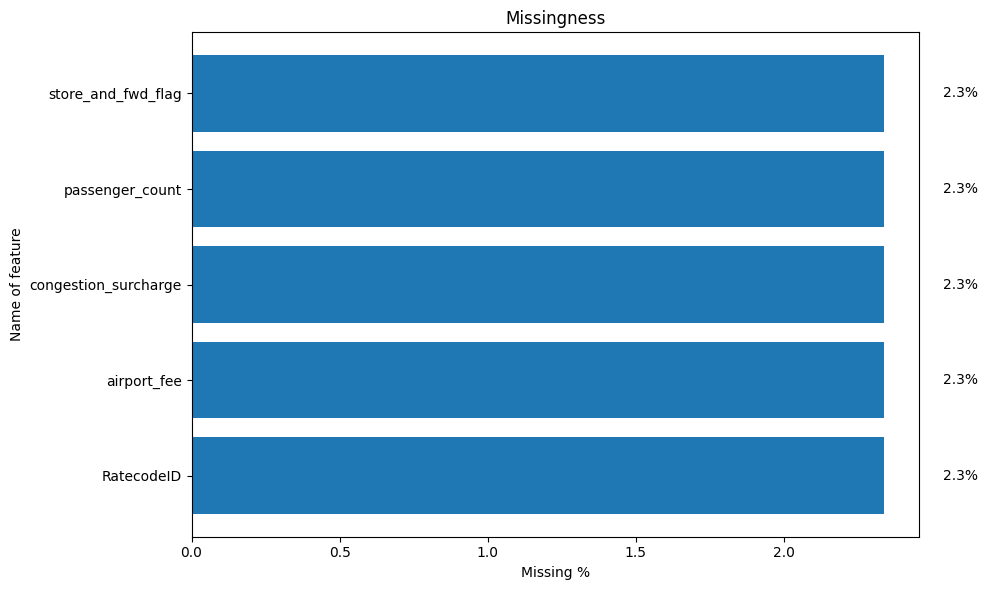

In [7]:
fig, ax = plt.subplots(figsize=[10,6])
ax.set_title('Missingness')
ax.set_xlabel('Missing %')
ax.set_ylabel('Name of feature')
bars = ax.barh(data['name'], data['%missing'])
for b, v in zip(bars, data['%missing']):
    ax.text(v + 0.2, b.get_y() + b.get_height()/2, f'{v:.1f}%', va='center')
plt.tight_layout()
plt.savefig(Path(Root_dir.joinpath('reports/figures/missingness_barplot.png')))

In [8]:
all_missing_cols = mt.loc[mt['all_missing'] == True, 'name'].to_list()
constant_cols = mt.loc[mt['constant'] == True, 'name'].to_list()
infinite_cols = mt.loc[mt['infinite'] > 0, 'name'].to_list()

In [9]:
problem = {
    "all_missing_cols": all_missing_cols,
    "constant_cols": constant_cols,
    "has_infinite_cols": infinite_cols,
}

In [10]:
output_path = Path(Root_dir.joinpath('reports/tables/problems_columns.json'))
output_path.parent.mkdir(parents=True, exist_ok=True)
with open(output_path, 'w') as f:
    json.dump(problem, f, indent=4)

Data Duplication Test

In [11]:
duplicate_count = df.duplicated(keep="first").sum()
pct_duplicated = duplicate_count/df.shape[0]*100
if duplicate_count > 0:
    print("\nSample duplicated rows:")
    display(df[df.duplicated(keep='first')].head(5))

In [13]:
obj_cols = [c for c in df.columns if df[c].dtype == "object"]
print(f"{len(obj_cols)} object columns:", obj_cols)


1 object columns: ['store_and_fwd_flag']


In [14]:
import pandas as pd

rows = []
n = len(df)

for name in obj_cols:
    s = df[name]
    pct_missing   = float(round(s.isna().mean() * 100, 1))
    n_unique      = int(s.nunique(dropna=True))
    unique_ratio  = float(n_unique / n) if n else 0.0

    # % that can be parsed as number / datetime (NaNs ignored by design)
    pct_num_parse = float(round(pd.to_numeric(s, errors="coerce").notna().mean() * 100, 1))
    pct_dt_parse  = float(round(pd.to_datetime(s, errors="coerce", infer_datetime_format=True)
                                .notna().mean() * 100, 1))

    rows.append({
        "name": name,
        "%missing": pct_missing,
        "n_unique": n_unique,
        "unique_ratio": unique_ratio,
        "%num_parse": pct_num_parse,
        "%dt_parse": pct_dt_parse
    })


C:\Users\dabhi\AppData\Local\Temp\ipykernel_10128\778564861.py:14: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  pct_dt_parse  = float(round(pd.to_datetime(s, errors="coerce", infer_datetime_format=True)
C:\Users\dabhi\AppData\Local\Temp\ipykernel_10128\778564861.py:14: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pct_dt_parse  = float(round(pd.to_datetime(s, errors="coerce", infer_datetime_format=True)


In [17]:
probe = pd.DataFrame(rows, columns=["name","%missing","n_unique","unique_ratio","%num_parse","%dt_parse"])

def suggest(row):
    if row["%num_parse"] >= 95:
        return "numeric"
    if row["%dt_parse"] >= 95:
        return "datetime"
    if (row["n_unique"] <= 50) or (row["unique_ratio"] <= 0.05):
        return "category"
    return "free_text"

probe["suggest"] = probe.apply(suggest, axis=1)
priority = {"numeric":0, "datetime":1, "category":2, "free_text":3}
probe["priority"] = probe["suggest"].map(priority)
probe


,name,%missing,n_unique,unique_ratio,%num_parse,%dt_parse,suggest,priority
0,store_and_fwd_flag,2.3,2,6.521528e-07,0.0,0.0,category,2


In [16]:
probe_sorted = probe.sort_values(
    ["priority", "unique_ratio", "%missing", "name"],
    ascending=[True, True, False, True]
).reset_index(drop=True)

display(probe_sorted.head(10))

print("\nSuggested numeric:",  probe_sorted.query("suggest=='numeric'")["name"].tolist())
print("Suggested datetime:", probe_sorted.query("suggest=='datetime'")["name"].tolist())
print("Category candidates:", probe_sorted.query("suggest=='category'")["name"].tolist())


,name,%missing,n_unique,unique_ratio,%num_parse,%dt_parse,suggest,priority
0,store_and_fwd_flag,2.3,2,6.521528e-07,0.0,0.0,category,2



Suggested numeric: []
Suggested datetime: []
Category candidates: ['store_and_fwd_flag']


In [18]:
rows, cols = df.shape

pct_rows_with_any_missing = round(df.isna().any(axis=1).mean() * 100, 1)

duplicates_count = int(df.duplicated(keep="first").sum())
duplicates_pct   = round(duplicates_count / rows * 100, 1)

all_missing_cols_count  = len(all_missing_cols)
constant_cols_count     = len(constant_cols)
has_infinite_cols_count = len(infinite_cols)

_top = mt.sort_values("%missing", ascending=False).head(5)[["name", "%missing"]]
top_missing = [(r["name"], float(r["%missing"])) for _, r in _top.iterrows()]

type_probe_counts = (
    probe["suggest"]
    .value_counts()
    .reindex(["numeric", "datetime", "category", "free_text"], fill_value=0)
    .to_dict()
)


In [19]:
quality_summary = {
    "rows": rows,
    "cols": cols,
    "pct_rows_with_any_missing": pct_rows_with_any_missing,
    "duplicates_count": duplicates_count,
    "duplicates_pct": duplicates_pct,
    "all_missing_cols_count": all_missing_cols_count,
    "constant_cols_count": constant_cols_count,
    "has_infinite_cols_count": has_infinite_cols_count,
    "top_missing": top_missing,  # list of (column, %missing)
    "type_probe_counts": type_probe_counts
}

quality_summary


{'rows': 3066766,
 'cols': 19,
 'pct_rows_with_any_missing': np.float64(2.3),
 'duplicates_count': 0,
 'duplicates_pct': 0.0,
 'all_missing_cols_count': 0,
 'constant_cols_count': 0,
 'has_infinite_cols_count': 0,
 'top_missing': [('RatecodeID', 2.339),
  ('airport_fee', 2.339),
  ('congestion_surcharge', 2.339),
  ('passenger_count', 2.339),
  ('store_and_fwd_flag', 2.339)],
 'type_probe_counts': {'numeric': 0,
  'datetime': 0,
  'category': 1,
  'free_text': 0}}

In [20]:
import json
out_path = Root_dir / "reports/tables/data_quality_summary.json"
out_path.parent.mkdir(parents=True, exist_ok=True)

with open(out_path, "w") as f:
    json.dump(quality_summary, f, indent=4)

print(f"✓ Saved: {out_path}")

# quick load-back sanity
with open(out_path) as f:
    loaded = json.load(f)

✓ Saved: D:\Portfolio\eda-portfolio\reports\tables\data_quality_summary.json


{'rows': 3066766,
 'cols': 19,
 'pct_rows_with_any_missing': 2.3,
 'duplicates_count': 0,
 'duplicates_pct': 0.0,
 'all_missing_cols_count': 0,
 'constant_cols_count': 0,
 'has_infinite_cols_count': 0,
 'top_missing': [['RatecodeID', 2.339],
  ['airport_fee', 2.339],
  ['congestion_surcharge', 2.339],
  ['passenger_count', 2.339],
  ['store_and_fwd_flag', 2.339]],
 'type_probe_counts': {'numeric': 0,
  'datetime': 0,
  'category': 1,
  'free_text': 0}}